In [1]:
import imageio as im
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy.ndimage import rotate
from scipy.optimize import minimize_scalar
import scipy.fft
from itertools import accumulate
import numpy.lib.stride_tricks as strides

In [2]:
base_dir = './sequencia_1/'
image_paths = sorted(os.listdir(base_dir))[1:]
images = [im.imread(f'{base_dir}{path}') for path in image_paths]

In [3]:
def scale_intensities(img, new_min=0, new_max=255):
    """
    Normalizes the image img to the range [new_min, new_max]. This is done by
    applying to all pixels p a funciton f(p) = ap + b such that for img.max(),
    f(img.max()) = new_max and for img.min(), f(img.min()) = new_min.
    """
    img_min = np.min(img, axis=(0,1))
    img_max = np.max(img, axis=(0,1))
    a = (new_max - new_min) / (img_max - img_min)
    b = new_min - img_min * a
    return a * img + b

def rgb_to_monochromatic(img):
    weights = np.array([0.144, 0.299, 0.587])
    return (img @ weights).astype(img.dtype)

def ensure_divisability(img, factor):
    a = img.shape[0] % factor
    rows = img if a == 0 else img[a // 2:-int(np.ceil(a / 2))]
    b = img.shape[1] % factor
    return rows if b == 0 else rows[:,b // 2:-int(np.ceil(b / 2))]

def calculate_partitions_shape(img, n_rows, n_cols):
    h = img.shape[0] // n_rows
    w = img.shape[1] // n_cols
    return (h, w) if img.ndim == 2 else (h, w, 1)

def calculate_strides_shape(partitions_shape, n_rows, n_cols):
    shape = (n_rows, n_cols) if len(partitions_shape) < 3 else (n_rows, n_cols, 3)
    return (*shape, *partitions_shape)

def calculate_partition_strides(sliding_windows, partitions_shape):
    padding = (0, len(sliding_windows.strides) - 2)
    weights = np.pad((partitions_shape[:2]), padding, constant_values=1)
    return weights * sliding_windows.strides

def partition_image(img, n_rows, n_cols):
    partitions_shape = calculate_partitions_shape(img, n_rows, n_cols)
    sliding_windows = strides.sliding_window_view(img, partitions_shape)
    shape = calculate_strides_shape(partitions_shape, n_rows, n_cols)
    partition_strides = calculate_partition_strides(sliding_windows, partitions_shape)
    return strides.as_strided(sliding_windows, shape=shape, strides=partition_strides)

def downsample_img(img, factor):
    used_img = ensure_divisability(img, factor)
    n_rows = used_img.shape[0] // factor
    n_cols = used_img.shape[1] // factor
    partitions = partition_image(used_img, n_rows, n_cols)
    partitions_axis = (2,3) if img.ndim == 2 else (3, 4, 5)
    return np.median(partitions, axis=partitions_axis).astype(img.dtype)

def threshold(img, percentage):
    return (img > np.percentile(img, 100*percentage)).astype(int)

In [4]:
def split_rgb_channels(img):
    return np.squeeze(np.split(img, 3, axis=-1), axis=-1)

def cross_correlate(img, filt):
    a, b = filt.shape[0] // 2, filt.shape[1] // 2
    padded = np.pad(img, ((a, a), (b, b)))
    nbhs = strides.sliding_window_view(padded, filt.shape)
    return np.sum(nbhs * filt, axis=(2,3))

def convolve(img, filt):
    return cross_correlate(img, np.flip(filt))

def generate_zero_centered_arange(size):
    center = size // 2
    return np.arange(size) - center

def compute_2d_gaussian(x, y, sigma):
    if sigma == 0:
        return np.ones_like(x)
    return 1 / (2 * np.pi * sigma2) * np.exp(x2 + y2 / (2 * sigma2))

def ensure_is_odd(value):
    return value + (1 - value % 2)

def compute_optimal_gaussian_filter_size(sigma):
    return ensure_is_odd(int(2 * sigma))

def generate_gaussian_filter(sigma=1):
    if sigma == 0:
        return np.array([[1]])
    filter_size = compute_optimal_gaussian_filter_size(sigma)
    zcrange = generate_zero_centered_arange(filter_size)
    x, y = np.meshgrid(zcrange, zcrange)
    filt = np.exp(-(np.square(x) + np.square(y)) / (2 * np.square(sigma)))
    return filt / np.sum(filt)

from scipy.ndimage import convolve

def apply_gaussian_filter(img, sigma=1):
    gaussian = generate_gaussian_filter(sigma=sigma)
    if img.ndim == 2:
        return convolve(img, gaussian)
    else:
        result = map(lambda channel: convolve(channel, gaussian), split_rgb_channels(img))
    return np.stack(tuple(result), axis=-1).astype(img.dtype)

Since only the grid in the images are going to be used to properly rotate the 
images, the images are going to be downsampled and only the luminance is going
to be utilized as an indication of color. This gives us the following images

In [5]:
used_images = list(map(lambda img: rgb_to_monochromatic(apply_gaussian_filter(downsample_img(img, 6), 2)), images))

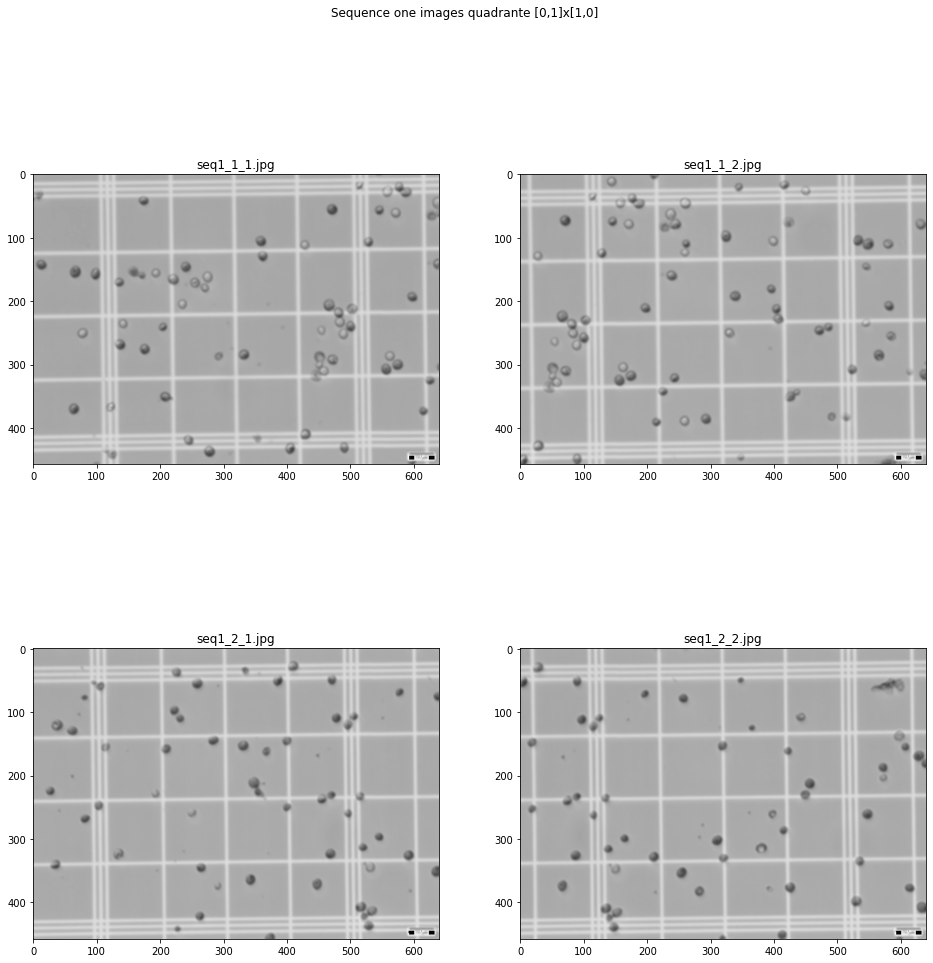

In [6]:
fig, axis = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('Sequence one images quadrante [0,1]x[1,0]')

axis[0, 0].set_title(image_paths[0])
axis[0, 0].imshow(used_images[0], cmap='gray')
axis[0, 1].set_title(image_paths[1])
axis[0, 1].imshow(used_images[1], cmap='gray')
axis[1, 0].set_title(image_paths[5])
axis[1, 0].imshow(used_images[5], cmap='gray')
axis[1, 1].set_title(image_paths[6])
axis[1, 1].imshow(used_images[6], cmap='gray')

<BarContainer object of 255 artists>

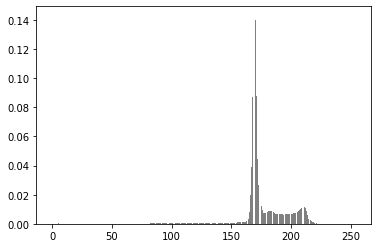

In [7]:
freq, bins = np.histogram(np.ravel(used_images), bins=np.max(used_images), density=True)
plt.bar(bins[:-1], freq, color='gray')

With this histogram, it can be seen that since the grid has the brightest color
in the monochromatic image, its gray level is probably within
the following interval:

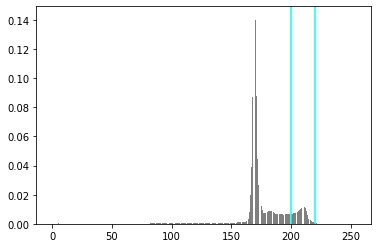

In [8]:
freq, bins = np.histogram(np.ravel(used_images), bins=np.max(used_images), density=True)
plt.bar(bins[:-1], freq, color='gray')
plt.axvline(200, color='cyan')
plt.axvline(220, color='cyan')

This way, since the grid is a good feature to identify and correct rotation, we
can isolate it with a thresholding transformation. For that, lets analyse the 
cumulative distribution of the graylevels

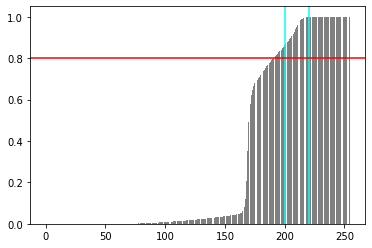

In [9]:
plt.bar(bins[:-1], list(accumulate(freq)), color='gray')
plt.axvline(200, color='cyan')
plt.axvline(220, color='cyan')
plt.axhline(y=0.8, color='red')

From it, we can see that taking the 0.85 point percentile of the distribution, 
we can threshold the grid as a binary image in the following way

In [10]:
thresholded = list(map(lambda img: threshold(img, 0.8), used_images))

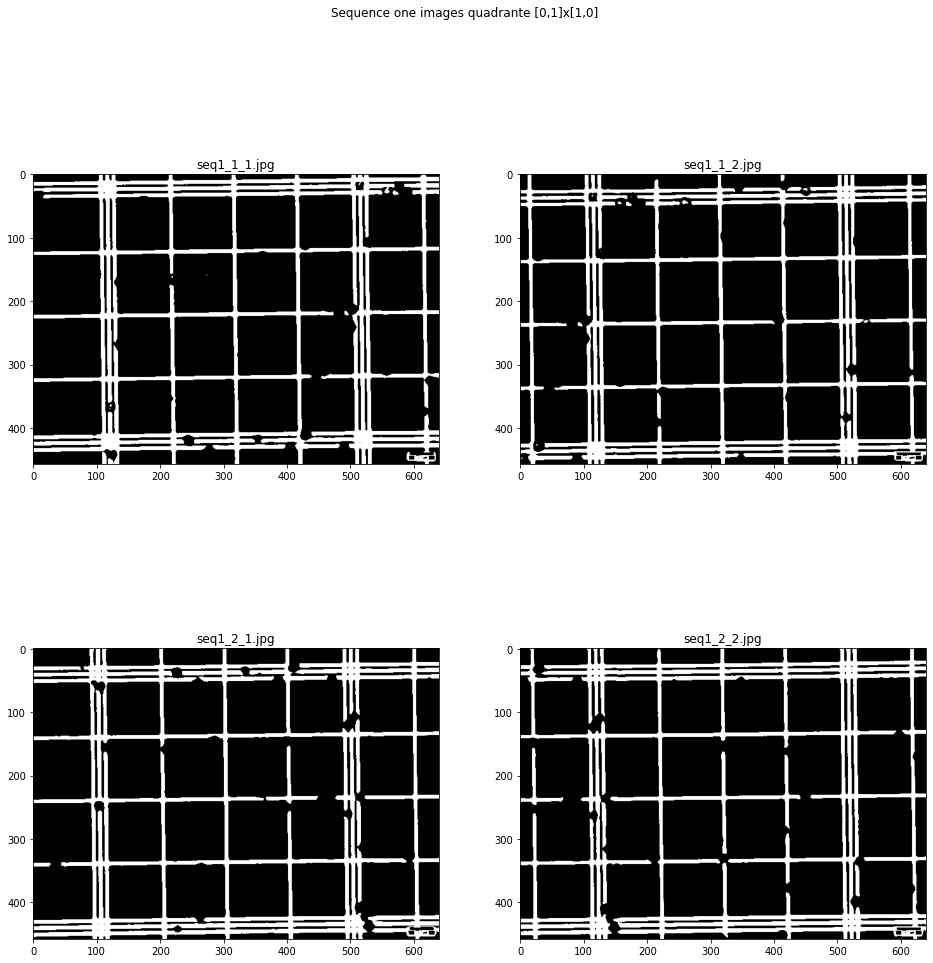

In [11]:
fig, axis = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('Sequence one images quadrante [0,1]x[1,0]')

axis[0, 0].set_title(image_paths[0])
axis[0, 0].imshow(thresholded[0], cmap='gray')
axis[0, 1].set_title(image_paths[1])
axis[0, 1].imshow(thresholded[1], cmap='gray')
axis[1, 0].set_title(image_paths[5])
axis[1, 0].imshow(thresholded[5], cmap='gray')
axis[1, 1].set_title(image_paths[6])
axis[1, 1].imshow(thresholded[6], cmap='gray')

Then we have that the texture of a thresholded grid image row $f_i$ can described
through the maximum probability value $\max_\{P_{f_i}\}$ in its color histogram
$P_{f_i}$, or in other words, the measure of how much participation the dominant
color has in the row. We also have that the distance between any two row texture
descriptors $P_g$ and $P_h$ can be described as $$|P_g - P_h|.$$ 

When a grid horizontal line is perfectly aligned with the axis, the dominant
color of the rows that represent it should have a histogram with a probability
of each pixel in that row having value one very close to one. For rows that do
not represent horizontal lines, in an ideal thresholded grid image, there 
should be a negligeble probability $c$ that a pixel has value zero (part of a vertical
line) and a probability $1 - c$ that a pixel has value one

Thus $c$ is ignored, and the row texture descriptor of an ideal thresholded grid
image that is aligned with the xy-axis is defined as row in which the color 
histogram has a maximum probability value of one. Now using this row texture as
a reference point, we minimize the sum of the distances between the row textures
of an image and the row textures of an ideal grid through iterative rotations to
obtain an estimator of the angle that must be used by a rotation to align the
image lines to the x axis. 

In [12]:
def binary_value_max_probability(array):
    probability_of_1 = np.sum(array) / np.prod(array.shape)
    return max(probability_of_1, 1 - probability_of_1)

def loss_function(img):
    row_max_probabilites = [binary_value_max_probability(row) for row in img]
    return img.shape[0] - np.sum(row_max_probabilites)

In [13]:
def correct_image_rotation_angle(img):
    def rotation(ang):
        return loss_function(rotate(img, angle=ang))
    result = minimize_scalar(rotation, tol=1e-8)
    return result.x

In [14]:
angles = [correct_image_rotation_angle(img) for img in thresholded]
rotation_fixed = [rotate(img, angle=ang, mode='reflect', reshape=False)
                  for img, ang in zip(used_images, angles)]

This way, we obtain the following rotation corrected images

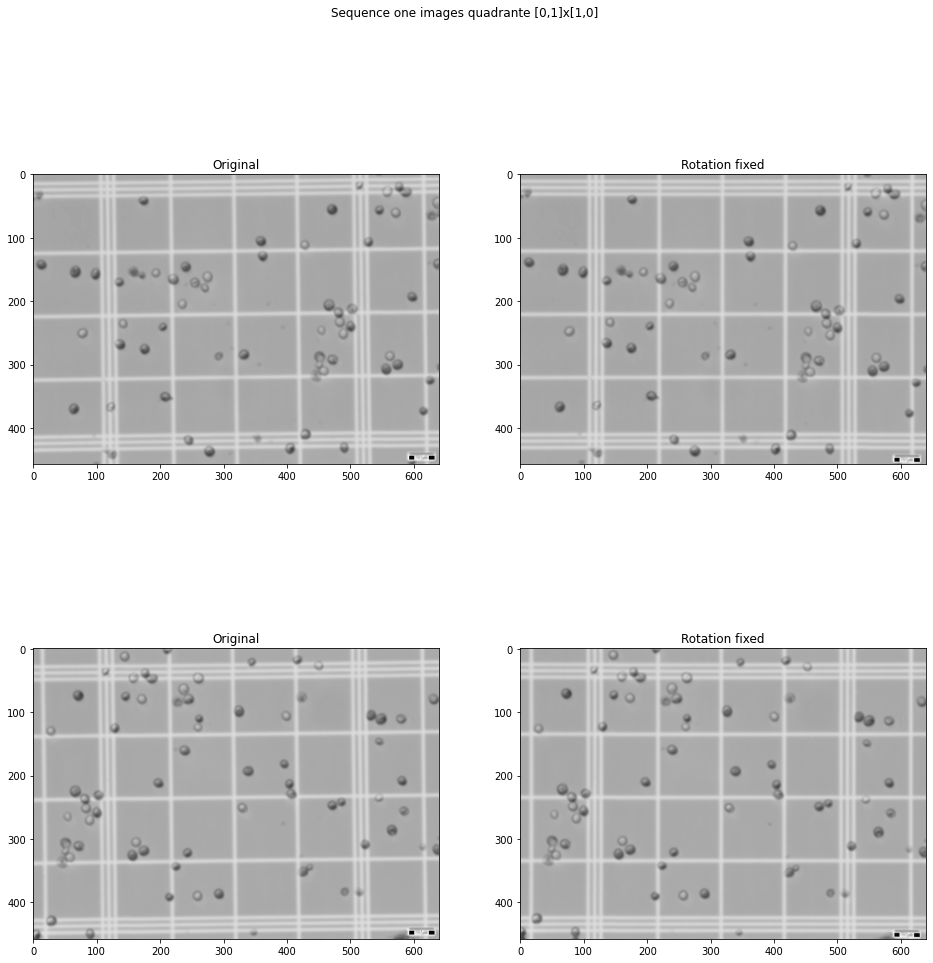

In [15]:
fig, axis = plt.subplots(2,2, figsize=(16,16))
fig.suptitle('Sequence one images quadrante [0,1]x[1,0]')

axis[0, 0].set_title('Original')
axis[0, 0].imshow(used_images[0], cmap='gray')
axis[0, 1].set_title('Rotation fixed')
axis[0, 1].imshow(rotation_fixed[0], cmap='gray')
axis[1, 0].set_title('Original')
axis[1, 0].imshow(used_images[1], cmap='gray')
axis[1, 1].set_title('Rotation fixed')
axis[1, 1].imshow(rotation_fixed[1], cmap='gray')

In [16]:
results = [rotate(img, angle=ang, mode='reflect', reshape=False) for img, ang in zip(images, angles)]

In [17]:
for img, image_path in zip(results, image_paths):
    im.imwrite(f'./rotation_fixed_1/{image_path}', img)